# Lens Modeling for `DESIJ0132-1600` with Lenstronomy

##### Author(s): **Fahim Rajit Hossain**, Anik Biswas, S M Rafee Adnan,

### Importing libraries

In [48]:
# import required python libraries
import corner
import h5py
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yaml
from google.colab import drive
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, param_util, util
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from light_profile import LightProfileAnalysis

!pip install emcee
!pip install corner
!pip install cobaya
!pip install lenstronomy




%matplotlib inline


drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading Data from h5 Files

In [ ]:
with h5py.File("DESIJ0132-1600_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"


kwargs_data

{'background_rms': 0.015737876438598787,
 'dec_at_xy_0': -7.239999999999993,
 'exposure_time': array([[495.25476, 403.6011 , 453.53333, ..., 472.42017, 412.46506,
         489.70682],
        [412.80304, 515.1279 , 476.61252, ..., 476.53165, 445.4861 ,
         535.7192 ],
        [482.8193 , 496.1837 , 400.38693, ..., 357.60785, 298.3937 ,
         396.26035],
        ...,
        [441.2676 , 450.2588 , 376.2917 , ..., 236.26028, 390.93497,
         169.68163],
        [616.7411 , 419.57428, 460.05017, ..., 258.5865 , 227.25743,
         498.26813],
        [421.1636 , 456.823  , 494.05148, ..., 491.05872, 234.55467,
         349.67188]], dtype=float32),
 'image_data': array([[ 0.00430852,  0.00739825,  0.01483097, ...,  0.61809156,
          0.73717307,  1.03075923],
        [ 0.00502319, -0.03017073, -0.00753662, ...,  0.57677819,
          0.67688715,  0.79889763],
        [ 0.01126465,  0.0042542 ,  0.00804784, ...,  0.50703695,
          0.57667449,  0.61907252],
        ...,
   

<ipython-input-3-f44519a307c8>:8: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-3-f44519a307c8>:11: RuntimeWarning: invalid value encountered in log10
  axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")


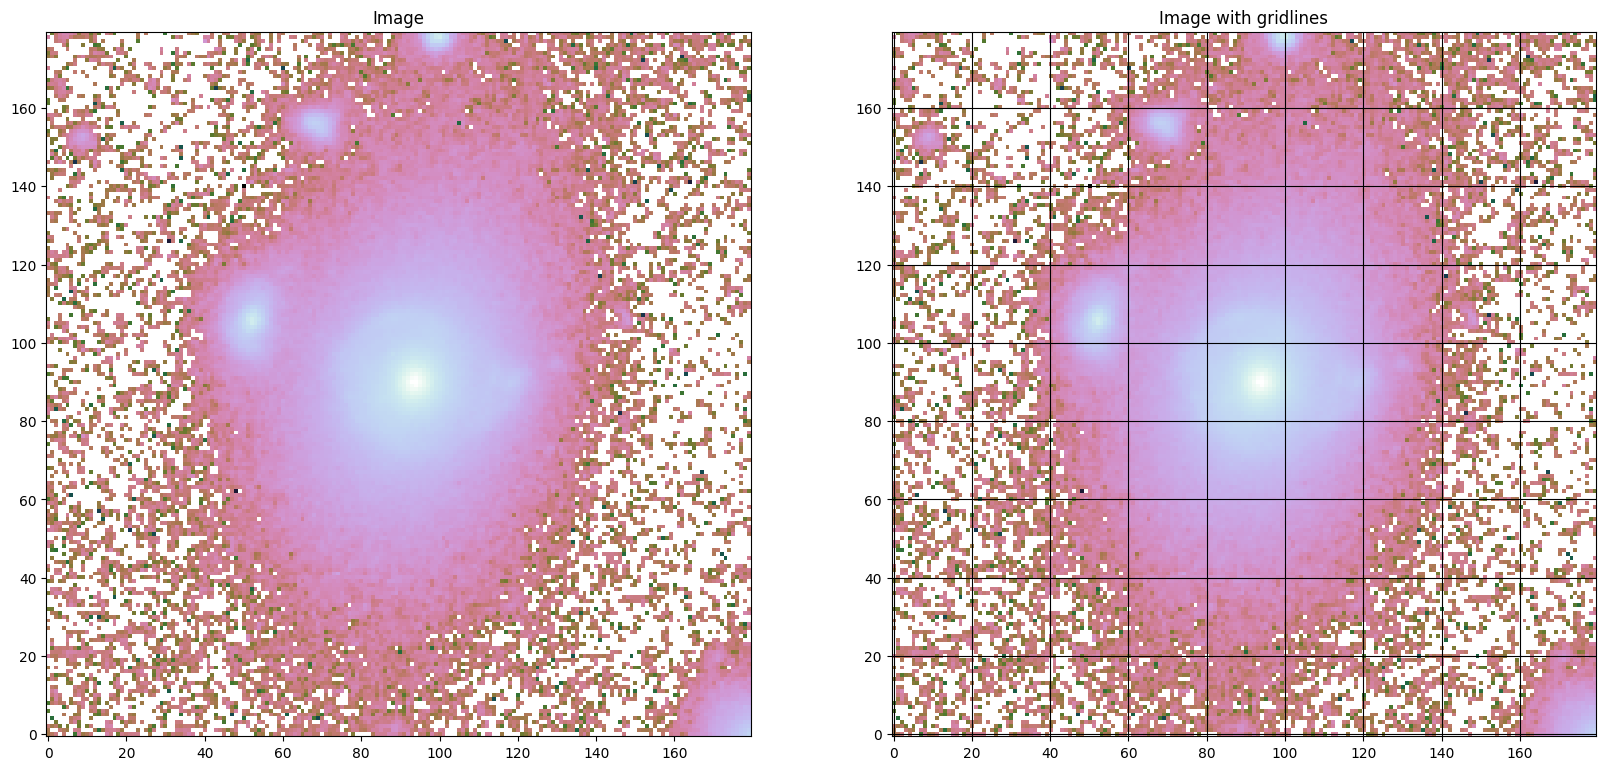

In [ ]:
# extracting image_data from kwargs_data

image = kwargs_data["image_data"]

# Make the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 20))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].set_title("Image")

axes[1].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[1].set_title("Image with gridlines")
axes[1].grid(True, color="black")

# Show the plots
plt.show()

## Creating Likelihood Mask

In [ ]:
# coordinate setup

ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

# Mask setup

r = 7.1  # arcsecond
# b = 4
lens_center_ra = 0
lens_center_dec = 0

mask_outer = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3,
    lens_center_dec + 1.2,
    1.1,
    1.7,
    np.pi / 10,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 1.8,
    lens_center_dec + 5.1,
    0.7,
    0.7,
    0,
)
mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.7,
    lens_center_dec + 6.7,
    0.7,
    0.7,
    0,
)
mask_ext_4 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.2,
    lens_center_dec + 0.23,
    0.3,
    0.3,
    0,
)

mask_ext_5 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 0.4,
    lens_center_dec - 0.1,
    0.25,
    0.25,
    0,
)


mask = (
    (1 - mask_outer)
    * (1 - mask_ext_1)
    * (1 - mask_ext_2)
    * (1 - mask_ext_3)
    * (1 - mask_ext_4)
    * (1 - mask_ext_5)
)
mask[mask >= 1] = 1
mask[mask < 0] = 0

mask_img_1 = mask.reshape(num_pix, num_pix)

### Setting the subplots


<ipython-input-5-4d2b903b9439>:3: RuntimeWarning: invalid value encountered in log10
  axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
<ipython-input-5-4d2b903b9439>:13: RuntimeWarning: divide by zero encountered in log10
  image_after_mask = np.log10(image * mask)
<ipython-input-5-4d2b903b9439>:13: RuntimeWarning: invalid value encountered in log10
  image_after_mask = np.log10(image * mask)


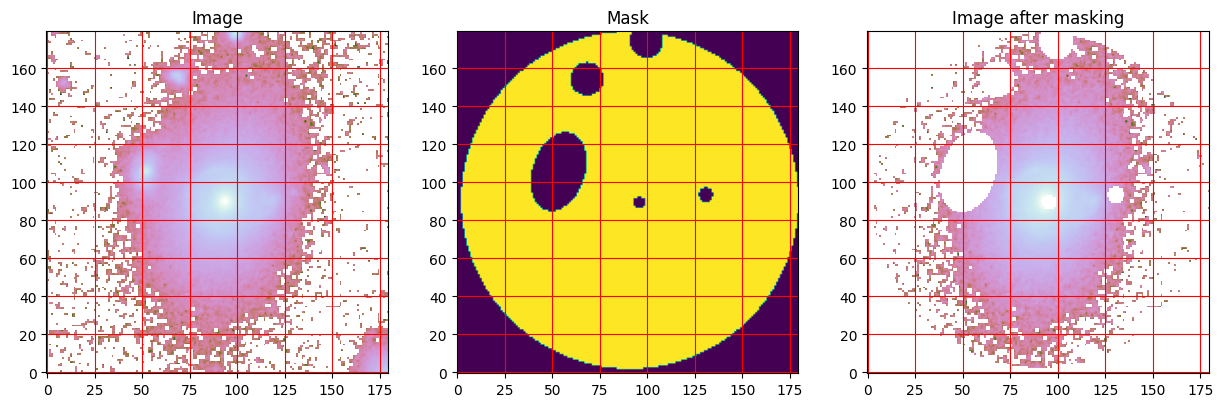

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(np.log10(image), origin="lower", cmap="cubehelix")
axes[0].grid(True, color="red")
axes[0].set_title("Image")

mask = mask.reshape(num_pix, num_pix)

axes[1].imshow(mask, origin="lower")
axes[1].grid(True, color="red")
axes[1].set_title("Mask")

image_after_mask = np.log10(image * mask)

axes[2].imshow(image_after_mask, origin="lower", cmap="cubehelix")
axes[2].grid(True, color="red")
axes[2].set_title("Image after masking")
# Show the plots
plt.show()

## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. We checked [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{qx^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

## Lens Modeling with Lenstronomy

In [ ]:
lens_model_list = ["EPL", "SHEAR"]
source_model_list = ["SHAPELETS"]
lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

## Lens Galaxy's Mass Model

### EPL Parameters

In [ ]:
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1.4,
        "gamma": 2,
        "e1": -0.0749,
        "e2": -0.12077,
        "center_x": -0.2102,
        "center_y": -0.0083,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.1,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 1,
        "gamma": 1,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 2.1,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

### SHEAR profile Parameters

In [ ]:
fixed_lens.append({"ra_0": 0, "dec_0": 0})


kwargs_lens_init.append({"gamma1": 0.066, "gamma2": -0.00263})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})

lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]

## Source Galaxy's Light Model

### Sersic Ellipse Parameters

### Shapelets Profile Parameters

In [ ]:
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({"n_max": 10})

kwargs_source_init.append({"center_x": -0.5522, "center_y": 0.045511, "beta": 0.07})
kwargs_source_sigma.append({"center_x": 0.2, "center_y": 0.2, "beta": 0.001})
kwargs_lower_source.append({"center_x": -10, "center_y": -10, "beta": 0.001})
kwargs_upper_source.append({"center_x": 10, "center_y": 10, "beta": 2})

source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]

# joint_shapelets_with_sersic = [[0, 1, ["center_x", "center_y"]]]

## Lens Galaxy's Light Model

### 1st Sersic Ellipse Parameters

In [ ]:
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({"n_sersic": 1.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 1.8705,
        "n_sersic": 2,
        "e1": -0.1897,
        "e2": -0.115,
        "center_x": -0.255,
        "center_y": -0.0594,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

### 2nd Sersic Ellipse Parameters

In [ ]:
fixed_lens_light.append({"n_sersic": 4.0})

kwargs_lens_light_init.append(
    {
        "R_sersic": 0.5280,
        "n_sersic": 2,
        "e1": -0.0355,
        "e2": -0.0266,
        "center_x": -0.2554,
        "center_y": -0.059,
        "amp": 16,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 1,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)

joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y", "e1", "e2"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]

### Combining all the above specification in the `kwargs_params` dictionary

In [ ]:
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
    # "joint_source_with_source": joint_shapelets_with_sersic,
}

### Numerical settings

In [ ]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask]}

kwargs_numerics = {"supersampling_factor": 3, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [ ]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band
    # has independent solutions of the
    # surface brightness, 'joint-linear':
    # there is one joint solution of the
    # linear coefficients demanded across the bands.
}

## Fitting the PSO sequence

In [ ]:
# using Particle Swarm Optimization

fitting_kwargs_list = [
    ["PSO", {"sigma_scale": 1.0, "n_particles": 100, "n_iterations": 100}]
]

fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
]

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list

kwargs_fixed_out = fitting_seq._updateManager.fixed_kwargs
output = [
    kwargs_result,
    multi_band_list_out,
    fit_output,
    kwargs_fixed_out,
]

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-0.9147811301432205 reduced X^2 of best position
-10629.756732264223 log likelihood
23240 effective number of data points
[{'theta_E': 1.393350027551597, 'gamma': 2, 'e1': -0.05711970132127305, 'e2': -0.1560875335023915, 'center_x': -0.1845904488341501, 'center_y': -0.009099761581753057}, {'gamma1': 0.06282054924256876, 'gamma2': -0.02804667354402401, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'n_max': 10, 'beta': 0.09994592463137579, 'center_x': -0.5383664845007539, 'center_y': 0.01767305288740048}] source result
[{'amp': 1, 'R_sersic': 1.8482916823615319, 'n_sersic': 1.0, 'e1': -0.12635819684790803, 'e2': -0.07911794065380306, 'center_x': -0.2598379937194476, 'center_y': -0.05521309636829983}, {'amp': 1, 'R_sersic': 0.36071082981972874, 'n_sersic': 4.0, 'e1': -0.12635819684790803, 'e2': -0.07911794065380306, 'center_x': -0.2598379937194476, 'center_y': -0.05521309636829983}] lens light result
[

In [ ]:
# saving PSO result

output_path = "./DESIJ0132-1600_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

## Visualizing the Fitted `PSO` Model

-0.9114866002627527 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9114866002627529


<ipython-input-33-f94fb0e6f230>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


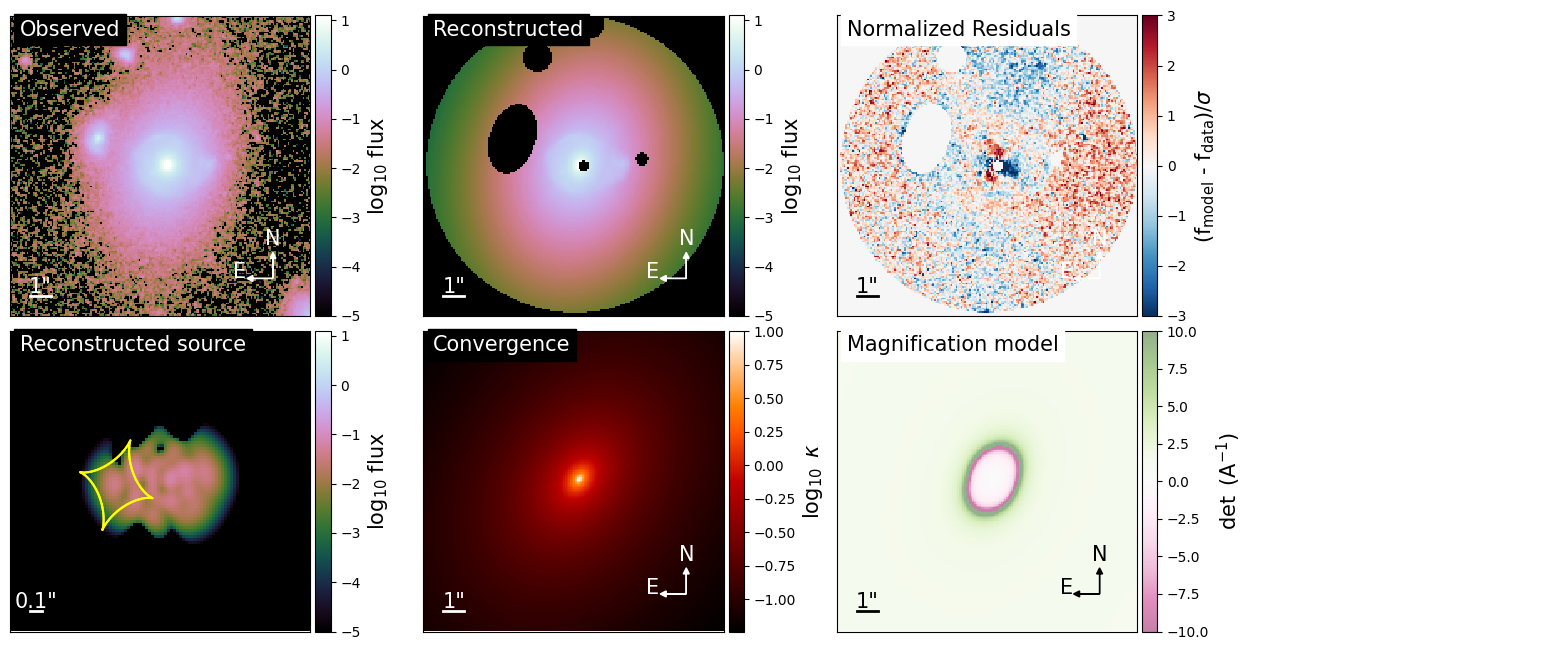

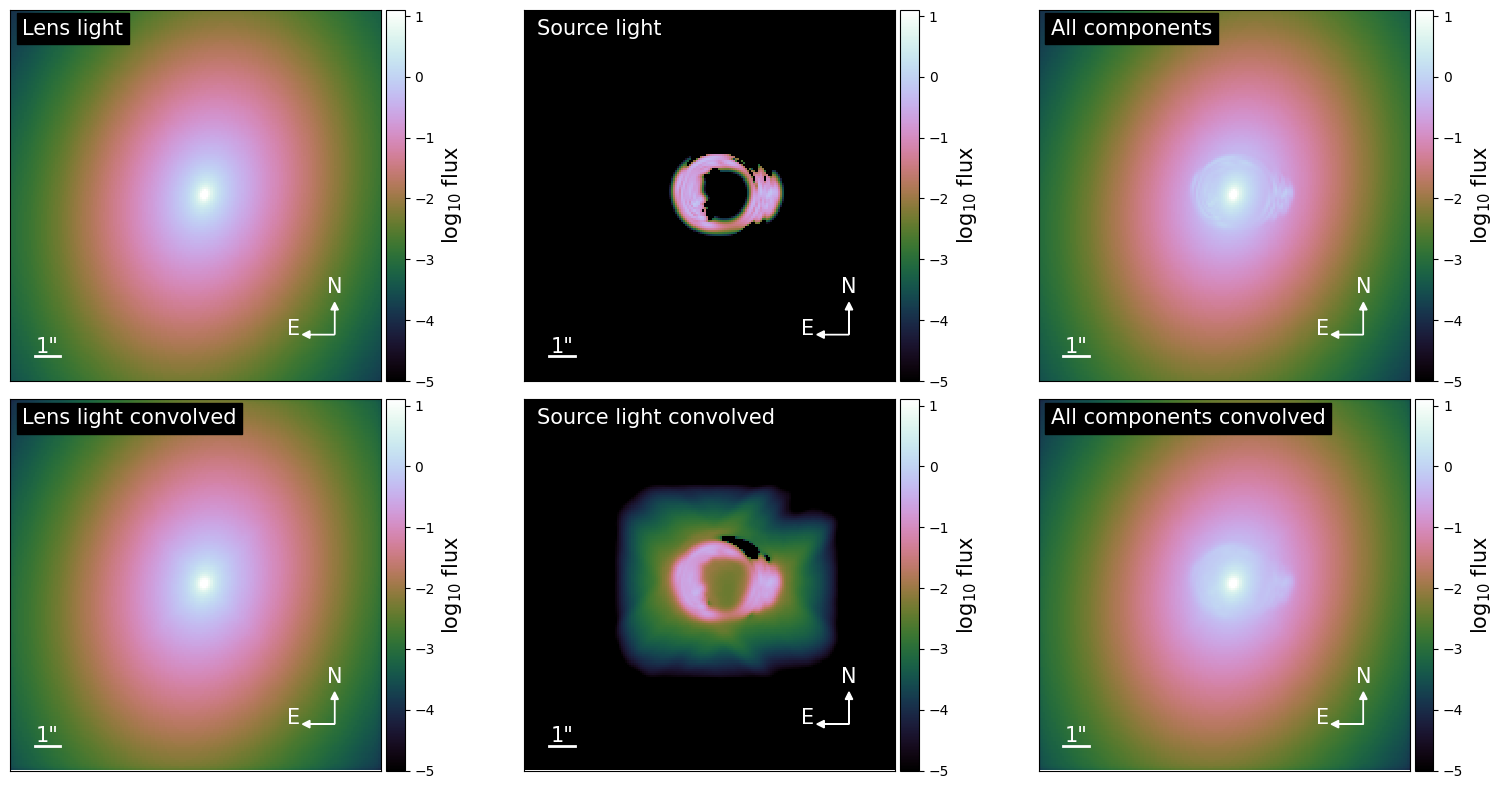

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.025, numPix=100, with_caustics=True
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

## the *MCMC* run

In [ ]:
# Define the path to the file on Google Drive
mcmc1_backend = "/content/drive/MyDrive/Fahim_code/mcmc1_backend.h5"

n_walkers = 80  #
n_step = 1  #
n_burn = 0


if mcmc1_backend:
    print("background file found")
    fitting_kwargs_list_mcmc = [
        [
            "MCMC",
            {
                "n_burn": n_burn,
                "n_run": n_step,
                "n_walkers": n_walkers,
                "sigma_scale": 0.1,
                "backend_filename": mcmc1_backend,
                "start_from_backend": True,
            },
        ]
    ]
else:
    print("creating background file")

    fitting_kwargs_list_mcmc = [
        [
            "MCMC",
            {
                "n_burn": n_burn,
                "n_run": n_step,
                "n_walkers": n_walkers,
                "sigma_scale": 0.1,
                "backend_filename": mcmc1_backend,
                "start_from_backend": True,
            },
        ]
    ]

fitting_seq_mcmc = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
)

chain_list_mcmc = fitting_seq_mcmc.fit_sequence(fitting_kwargs_list_mcmc)
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()

background file found


100%|██████████| 1/1 [01:34<00:00, 94.28s/it]

Computing the MCMC...
Number of walkers =  80
Burn-in iterations:  0
Sampling iterations (in current run): 1
96.4562087059021 time taken for MCMC sampling


In [ ]:
kwargs_result_mcmc = fitting_seq_mcmc.best_fit()
print(kwargs_result_mcmc)

{'kwargs_lens': [{'theta_E': 1.4007314005497553, 'gamma': 1.1199515562467628, 'e1': -0.09487492255911338, 'e2': -0.05393980734685824, 'center_x': -0.12279250407677429, 'center_y': 0.04706304979362512}, {'gamma1': -0.07934976189171297, 'gamma2': -0.04304306235979153, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'n_max': 10, 'beta': 0.029186096735629188, 'center_x': -0.17288887504831885, 'center_y': 0.02495382585254329}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 1.8569494578011922, 'n_sersic': 1.0, 'e1': -0.15790804469313535, 'e2': -0.09356480166467597, 'center_x': -0.26581098469305914, 'center_y': -0.05380208877549952}, {'amp': 1, 'R_sersic': 0.29684276954660194, 'n_sersic': 4.0, 'e1': -0.15790804469313535, 'e2': -0.09356480166467597, 'center_x': -0.26581098469305914, 'center_y': -0.05380208877549952}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [ ]:
if len(chain_list_mcmc) > 0:
    for i, chain in enumerate(chain_list_mcmc):
        print(f"Chain {i + 1}:")
        print("Sampler type:", chain[0])
        print("Parameter names:", chain[2])
        print("Shape of samples:", chain[1].shape)
        print("")

    # Alternatively, you can access the last chain directly

    last_chain = chain_list_mcmc[-1]
    last_samples = last_chain[1]
    last_param_names = last_chain[2]
    print("Last Chain:")
    print("Sampler type:", last_chain[0])
    print("Parameter names:", last_param_names)
    print("Shape of samples:", last_samples.shape)
else:
    print("No MCMC chains available.")

Chain 1:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (170640, 17)

Last Chain:
Sampler type: EMCEE
Parameter names: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Shape of samples: (170640, 17)


## Visualizing the MCMC chain: `traceplot`

<ipython-input-19-2106b2fc90b3>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc == []:


N_step: 2133, N_walkers: 80, N_params: 17
theta_E_lens0 1.4043 ± 0.0042
gamma_lens0 1.1456 ± 0.0227
e1_lens0 -0.0989 ± 0.0087
e2_lens0 -0.0522 ± 0.0124
center_x_lens0 -0.1218 ± 0.0063
center_y_lens0 0.0394 ± 0.0077
gamma1_lens1 -0.0804 ± 0.0072
gamma2_lens1 -0.0384 ± 0.0115
beta_source_light0 0.0347 ± 0.0059
center_x_source_light0 -0.1794 ± 0.0094
center_y_source_light0 0.0189 ± 0.0074
R_sersic_lens_light0 1.8466 ± 0.0080
e1_lens_light0 -0.1555 ± 0.0014
e2_lens_light0 -0.0928 ± 0.0012
center_x_lens_light0 -0.2655 ± 0.0008
center_y_lens_light0 -0.0529 ± 0.0008
R_sersic_lens_light1 0.2983 ± 0.0047


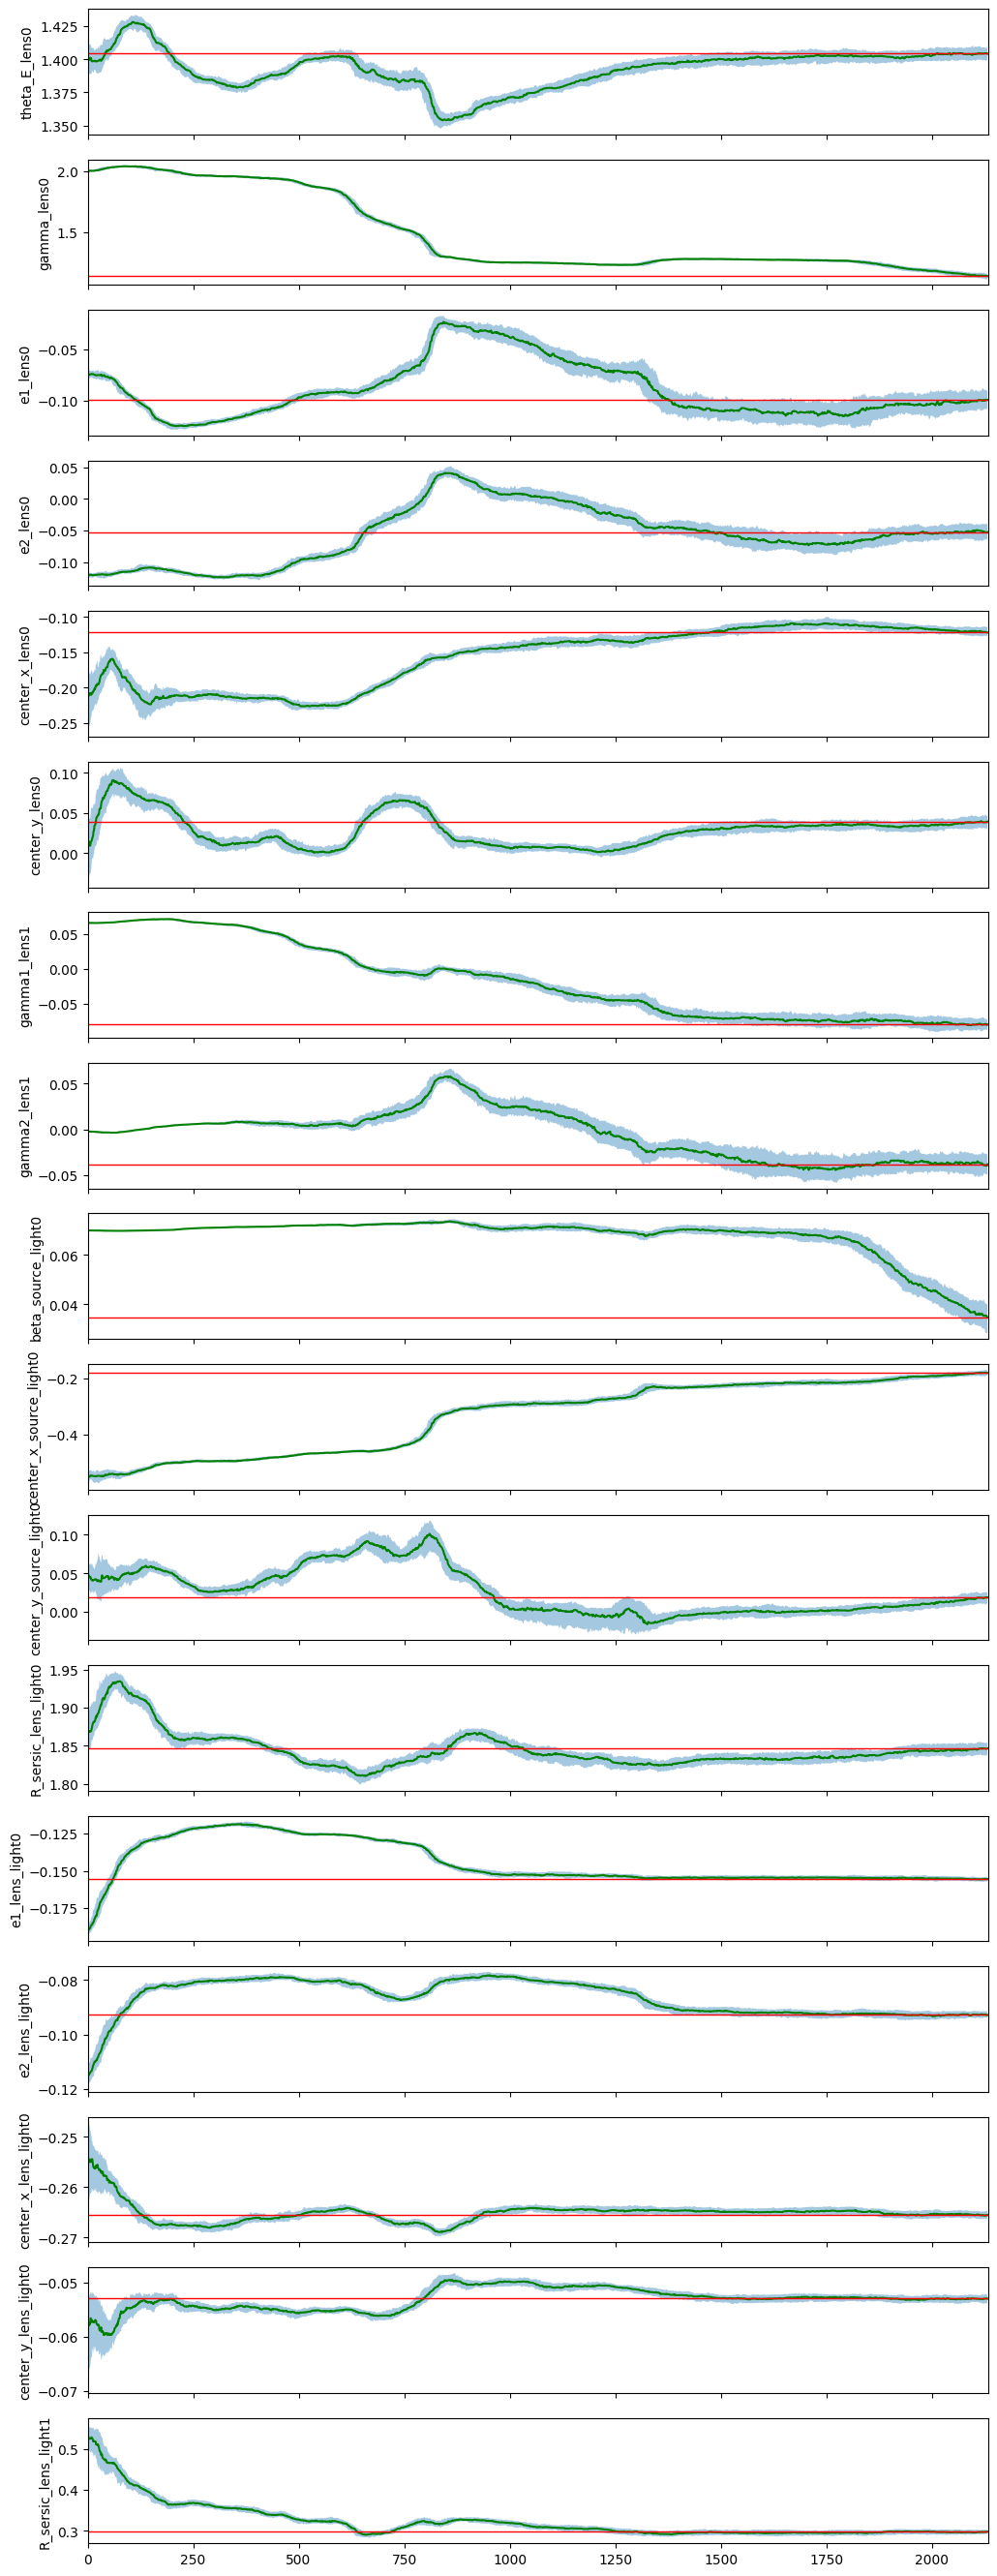

In [ ]:
# Traceplot

samples_mcmc = []

if chain_list_mcmc[-1][0] != "PSO":
    # if MCMC chain was broken in the chunks,
    # we join the chunks to make the full chain
    mcmc_repeat = 1

    for k in range(len(chain_list_mcmc) - mcmc_repeat, len(chain_list_mcmc)):
        samples_mcmc = chain_list_mcmc[k][1]

        param_mcmc = chain_list_mcmc[k][2]

if not samples_mcmc == []:
    n_params = samples_mcmc.shape[1]

    n_walkers = 80  # Adjust the walker ratio as needed
    n_step = int(samples_mcmc.shape[0] / n_walkers)

    print("N_step: {}, N_walkers: {}, N_params: {}".format(n_step, n_walkers, n_params))

    chain = np.empty((n_walkers, n_step, n_params))

    for i in range(n_params):
        samples = samples_mcmc[:, i]
        reshaped_samples = samples.reshape((n_walkers, n_step), order="F")
        chain[:, :, i] = reshaped_samples

    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))

    for i in range(n_params):
        for j in range(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.0)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.0)

    fig, ax = plt.subplots(n_params, sharex=True, figsize=(8, 6))

    burnin = -1
    last = n_step

    medians = []

    param_values = [
        median_pos[0][last - 1],
        (q84_pos[0][last - 1] - q16_pos[0][last - 1]) / 2,
        median_pos[1][last - 1],
        (q84_pos[1][last - 1] - q16_pos[1][last - 1]) / 2,
    ]

    for i in range(n_params):
        print(
            param_mcmc[i],
            "{:.4f} ± {:.4f}".format(
                median_pos[i][last - 1],
                (q84_pos[i][last - 1] - q16_pos[i][last - 1]) / 2,
            ),
        )

        ax[i].plot(median_pos[i][:last], c="g")
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c="r", lw=1)
        ax[i].fill_between(
            np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4
        )
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)

        medians.append(np.median(median_pos[i][burnin:last]))

    if True:
        fig.set_size_inches((12.0, 2 * len(param_mcmc)))
        plt.show()

## `Corner Plot`

Number of non-linear parameters in the MCMC process: 17
Parameters in order: ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'beta_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0', 'R_sersic_lens_light1']
Number of evaluations in the MCMC process: 170640
170640
Shape of samples_mcmc_cut: (1360, 17)


<ipython-input-21-5696c3fbc635>:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if not samples_mcmc_cut == []:


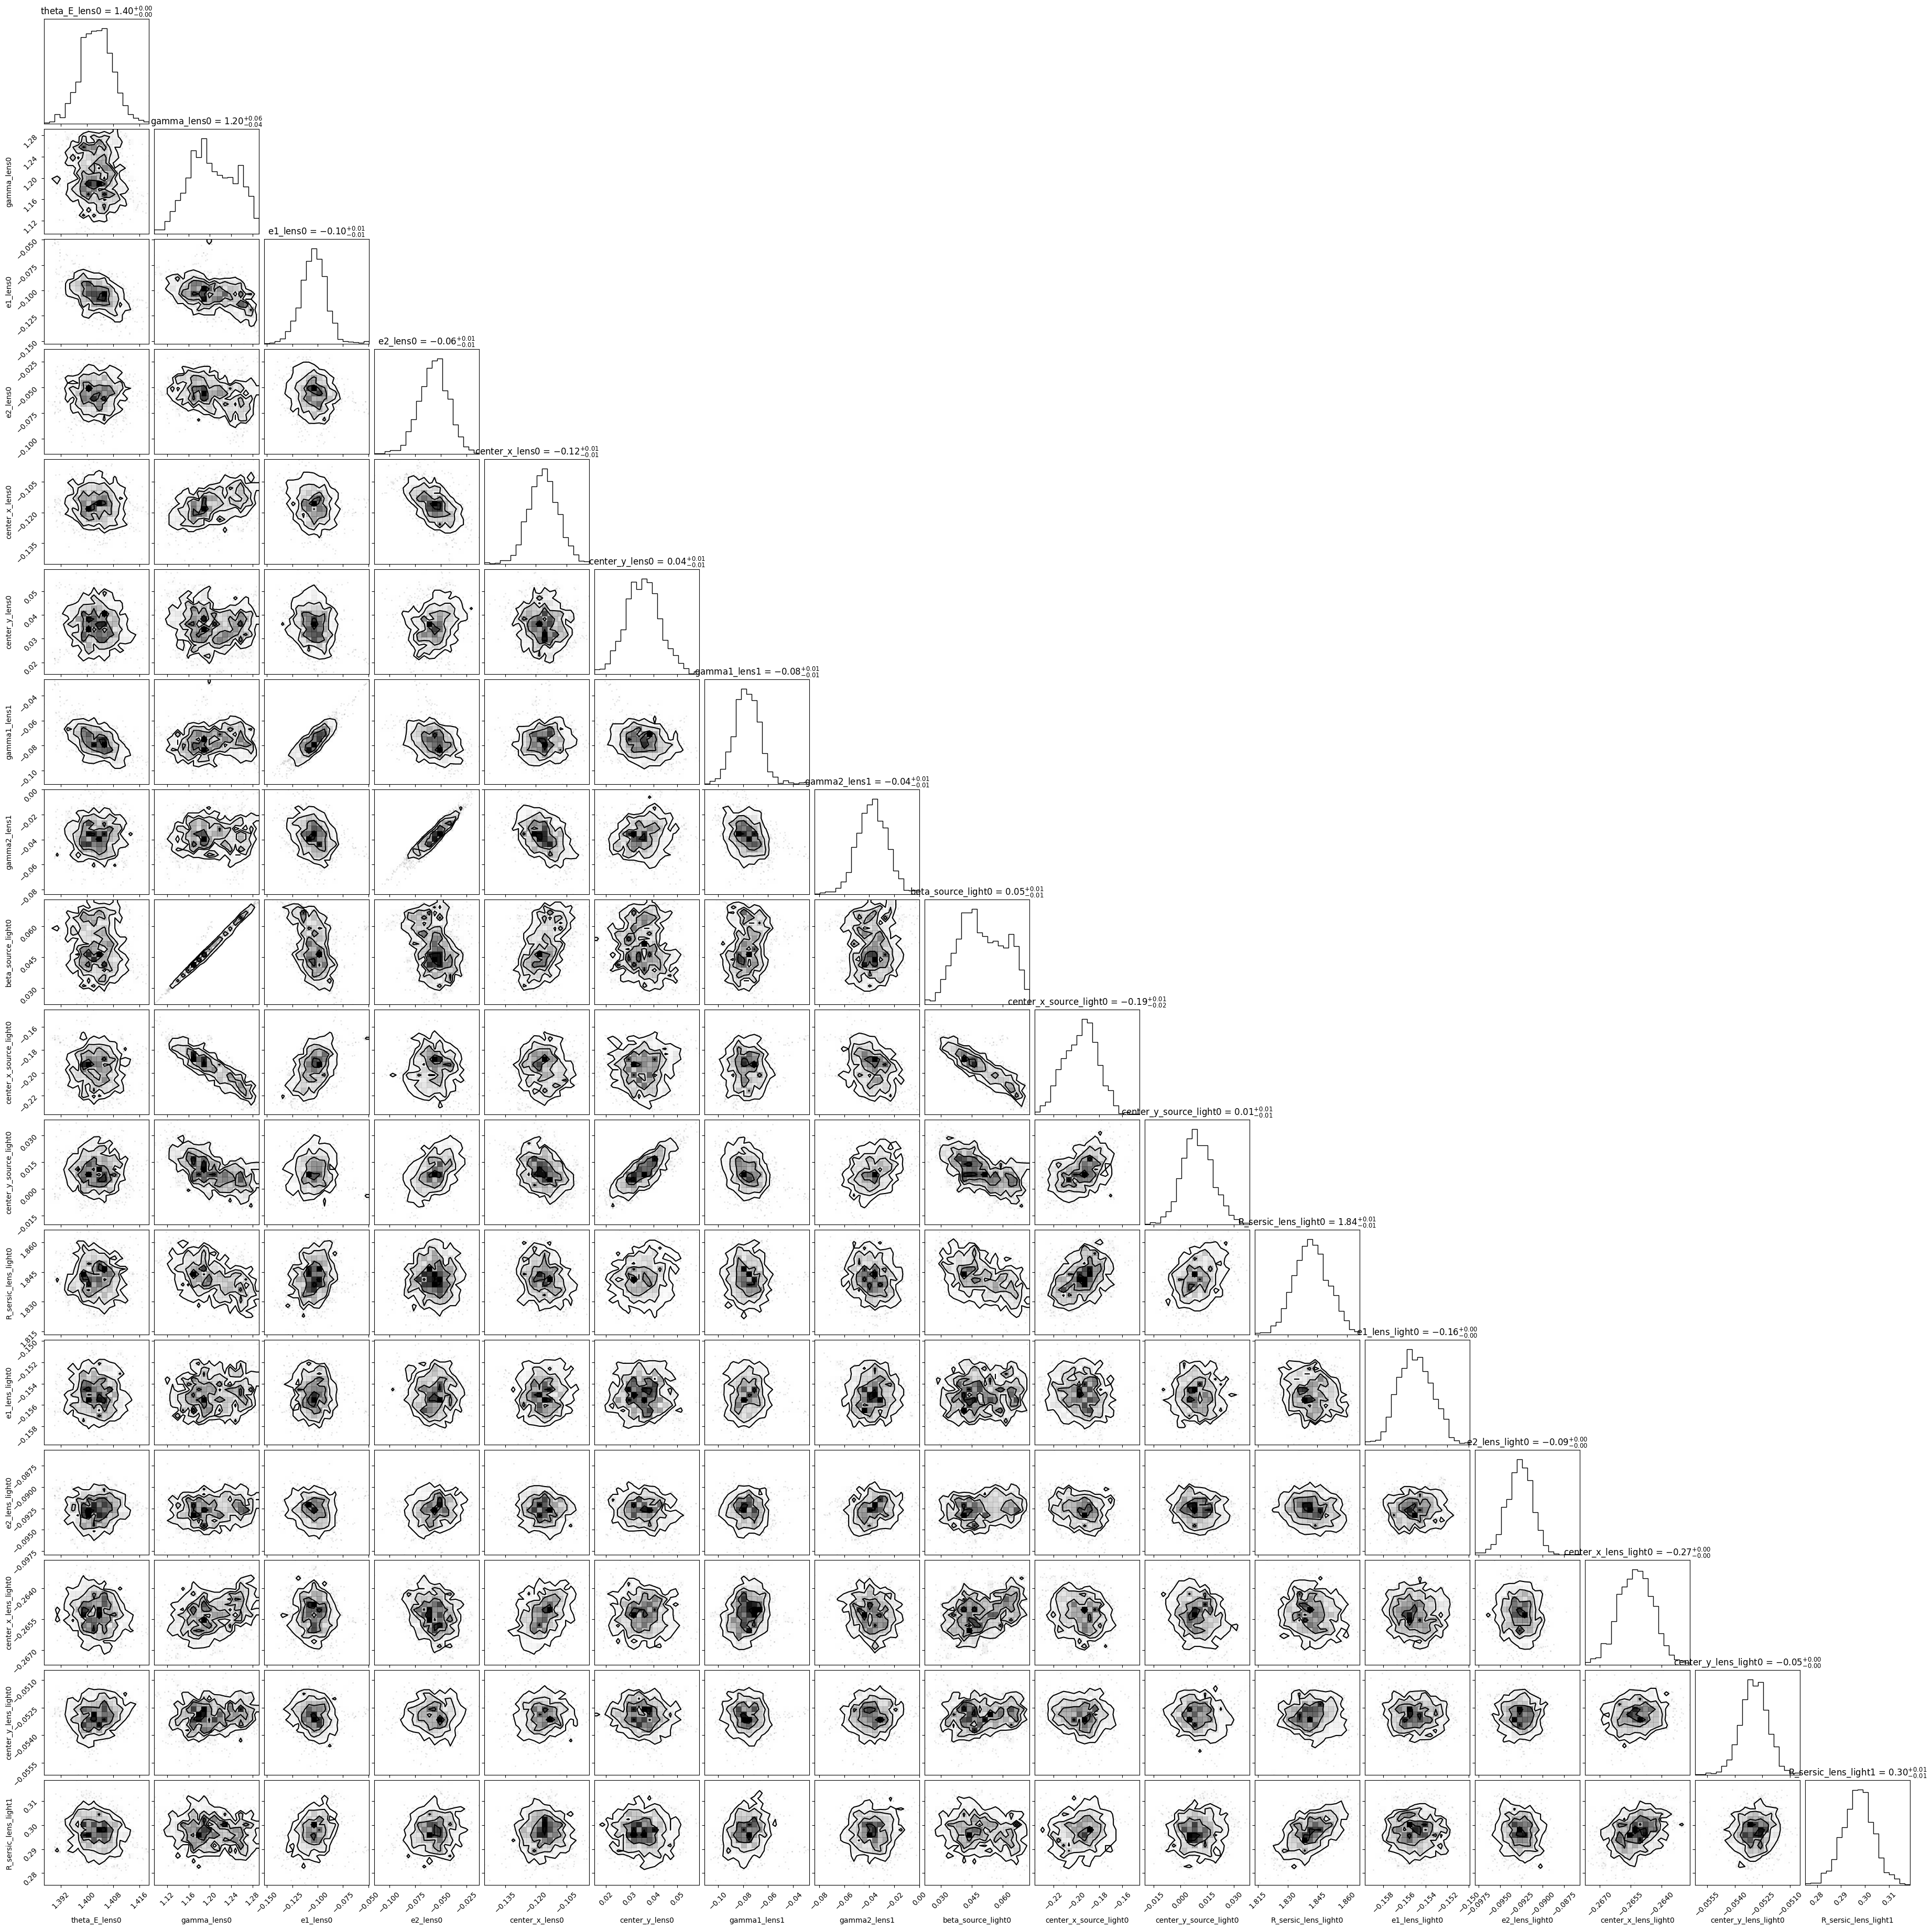

In [ ]:
if len(chain_list_mcmc) > 0:
    sampler_type, samples_mcmc, param_mcmc, dist_mcmc = chain_list_mcmc[0]

    param_class = fitting_seq_mcmc.param_class

    print("Number of non-linear parameters in the MCMC process:", len(param_mcmc))
    print("Parameters in order:", param_mcmc)
    if samples_mcmc is not None:
        print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
        n_sample = len(samples_mcmc)
        print(n_sample)
        burnin = 1800
        thin = 20
        samples_mcmc_cut = chain[:, burnin::thin, :].reshape((-1, n_params))
        if not samples_mcmc_cut == []:
            n, num_param = np.shape(samples_mcmc_cut)
            print("Shape of samples_mcmc_cut:", samples_mcmc_cut.shape)
            plot = corner.corner(samples_mcmc_cut, labels=param_mcmc, show_titles=True)
    else:
        print("No samples available for corner plot.")
else:
    print("No MCMC chains available.")

## Visualizing the fitted model with `MCMC`

-0.8466168326345493 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.8466168326345495


/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:63: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:148: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:211: RuntimeWarning: divide by zero encountered in log10
  np.log10(self._model),
<ipython-input-22-58863f6eef99>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


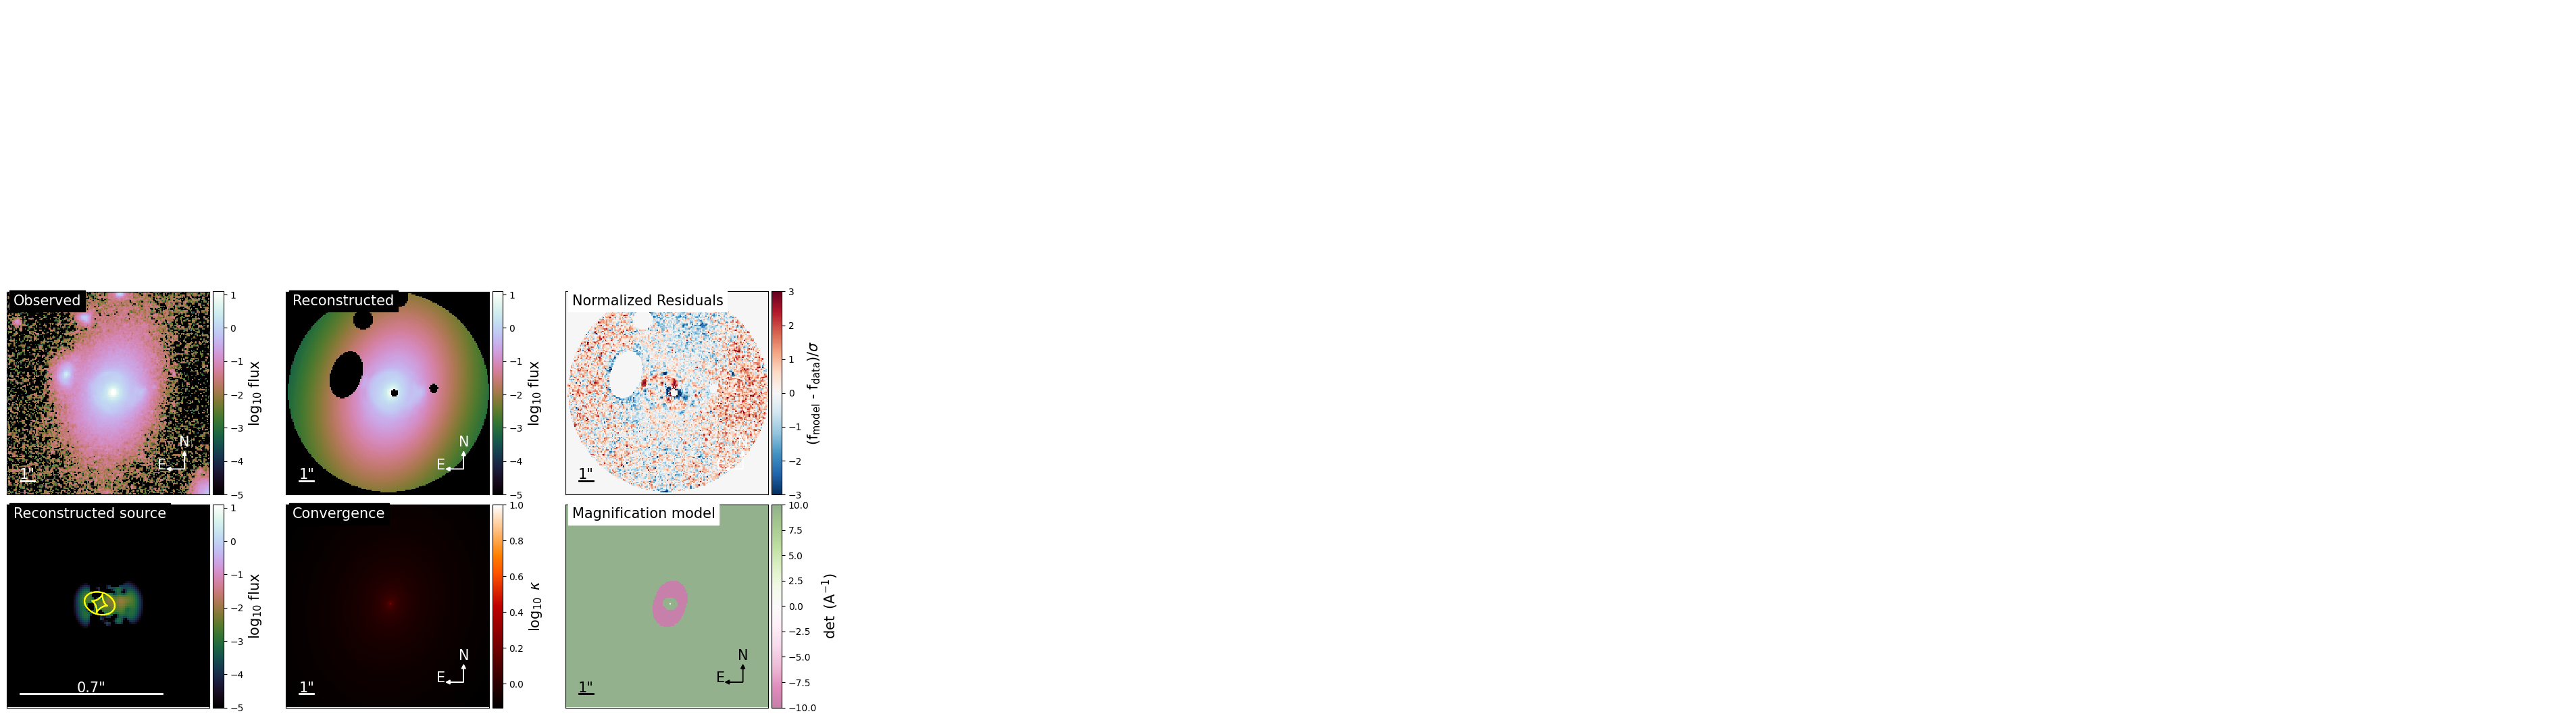

/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: divide by zero encountered in log10
  np.log10(model),
/usr/local/lib/python3.10/dist-packages/lenstronomy/Plots/model_band_plot.py:1062: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


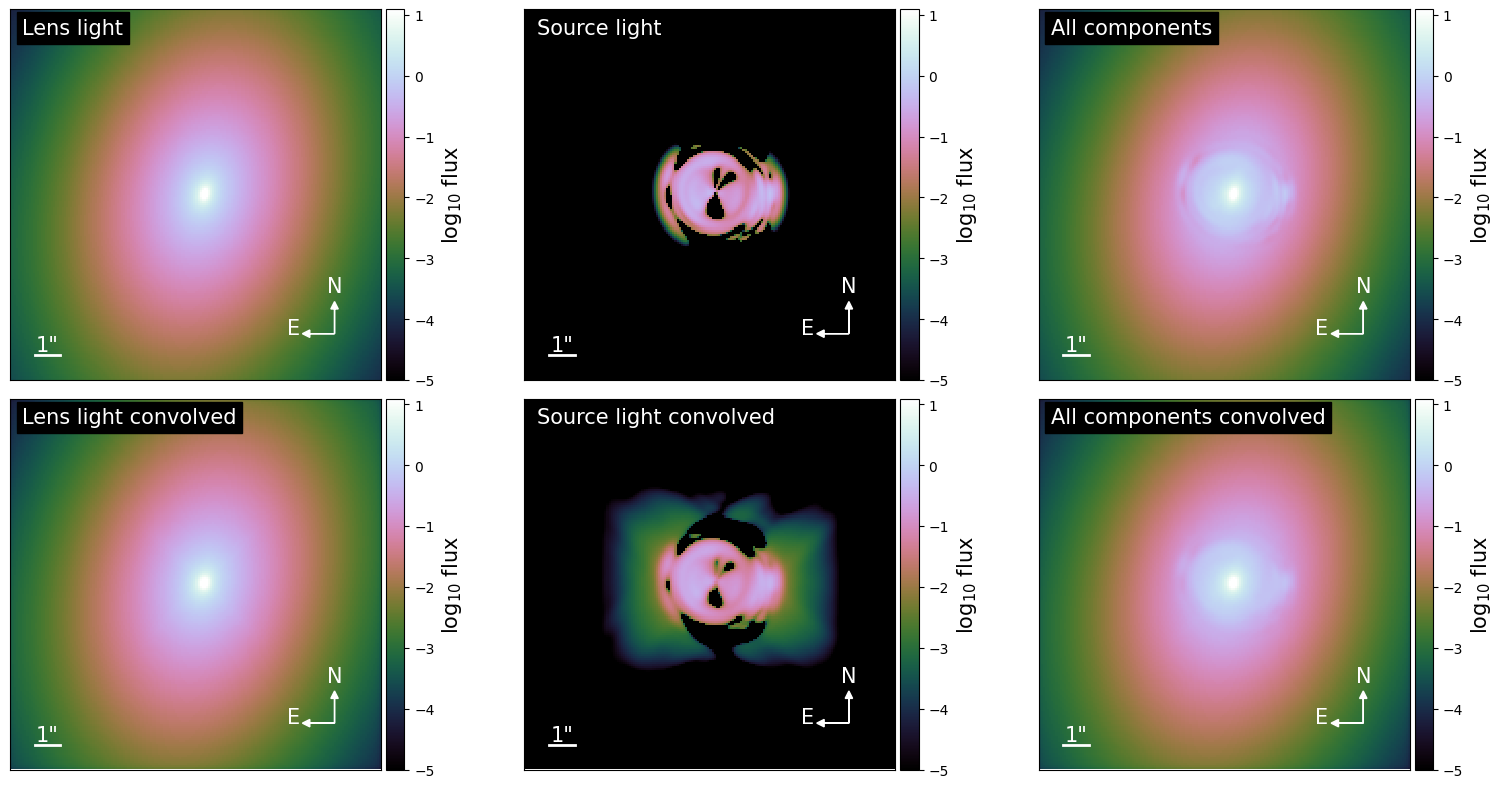

{'kwargs_lens': [{'theta_E': 1.4007314005497553, 'gamma': 1.1199515562467628, 'e1': -0.09487492255911338, 'e2': -0.05393980734685824, 'center_x': -0.12279250407677429, 'center_y': 0.04706304979362512}, {'gamma1': -0.07934976189171297, 'gamma2': -0.04304306235979153, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': array([ 1.09702222e+02, -3.64926271e+01,  3.85214119e+01,  4.70613242e+01,
       -1.61477157e+01, -7.44436881e+00, -4.02002407e+01,  1.66629101e+01,
       -1.27635433e+01, -1.26217770e+01,  4.19048741e+01, -1.60661746e+01,
       -1.18618514e+01,  1.08135650e-01, -1.09897439e+01, -2.36933083e+01,
        2.72645889e+01, -4.88155421e+00, -1.03590433e+01,  4.64910313e+00,
       -4.61466531e-01,  1.90792230e+01, -1.00536706e+01,  1.13032141e+01,
        8.28624855e+00, -1.20742172e+00,  8.37309567e-01,  1.39553890e+00,
        4.78479028e+00,  1.44527425e+01,  3.07316381e+00, -9.50826888e+00,
       -2.27529439e+00,  8.69444053e+00, -7.94589416e+00,  5.09986709e+00,
       

In [ ]:
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result_mcmc,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0], deltaPix_source=0.01, numPix=100, with_caustics=True, scale_size=0.7
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)

f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

print(kwargs_result_mcmc)

### Mass and Light Ellipticity of the Lens Galaxy

In [47]:
result_mass_e1 = kwargs_result_mcmc["kwargs_lens"][0]["e1"]
result_mass_e2 = kwargs_result_mcmc["kwargs_lens"][0]["e2"]

result_light_e1 = kwargs_result_mcmc["kwargs_lens_light"][0]["e1"]
result_light_e2 = kwargs_result_mcmc["kwargs_lens_light"][0]["e2"]

mass_phi, mass_q = ellipticity2phi_q(result_mass_e1, result_mass_e2)
light_phi, light_q = ellipticity2phi_q(result_light_e1, result_light_e2)

print(
    "mass_q: {},\nlight_q: {}, \nmass_phi: {}, \nlight_phi: {}".format(
        mass_q, light_q, mass_phi, light_phi
    )
)

mass_q: 0.8032047280001399,
light_q: 0.6898364169542527, 
mass_phi: -1.3123149115464723, 
light_phi: -1.3033430124108363


## `MCMC` Output

In [ ]:
multi_band_list_out = fitting_seq_mcmc.multi_band_list
kwargs_fixed_out = fitting_seq_mcmc.kwargs_fixed

init_samples = n_step  # cannot be 'None' for MCMC

input = [
    fitting_kwargs_list_mcmc,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]

if samples_mcmc is not None:
    print("Number of evaluations in the MCMC process:", np.shape(samples_mcmc)[0])
    n_sample = len(samples_mcmc)
    print(n_sample)
    burnin = 1890
    thin = 20
    shortened_samples_mcmc = chain[:, burnin::thin, :].reshape((-1, n_params))
print("Shape of shortened_samples_mcmc:", shortened_samples_mcmc.shape)

output = [
    kwargs_result_mcmc,
    multi_band_list_out,
    kwargs_fixed_out,
    shortened_samples_mcmc,
    param_mcmc,
]

output_path = "./DESIJ0132-1600_mcmc_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)

Number of evaluations in the MCMC process: 170640
170640
Shape of shortened_samples_mcmc: (1040, 17)


### Uncertainty calculation for the theta_E, gamma, and center coordinates of the lens Galaxy

### Parameters Without Conversion

In [ ]:
# The list of parameters to be included in the yaml file without conversion
list_params = [
    "theta_E_lens0",
    "gamma_lens0",
    "center_x_lens0",
    "center_y_lens0",
    "center_x_lens_light0",
    "center_y_lens_light0",
]

# Uncertainty calculation
median_sample = np.zeros(n_params)
q16_sample = np.zeros(n_params)
q84_sample = np.zeros(n_params)
values = {}

for i in range(n_params):
    median_sample[i] = np.median(shortened_samples_mcmc[:, i])
    q16_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 16.0)
    q84_sample[i] = np.percentile(shortened_samples_mcmc[:, i], 84.0)

    values[param_mcmc[i]] = [
        median_sample[i],
        q84_sample[i] - median_sample[i],
        median_sample[i] - q16_sample[i],
    ]
# parameters filtered by list params
parameter_values = {k: values.get(k) for k in list_params}
print("\n", parameter_values)  # ['theta_E_lens0'][0])


 {'theta_E_lens0': [1.4034012473926518, 0.004675742237349567, 0.004768238352823362], 'gamma_lens0': [1.1842249856044433, 0.03590261927335292, 0.034149442635775795], 'center_x_lens0': [-0.11809810905731624, 0.006895165557872673, 0.0061806330627103], 'center_y_lens0': [0.035648714713870946, 0.007761500711932295, 0.007778378366993591], 'center_x_lens_light0': [-0.2654059392670315, 0.0008044686363629094, 0.0008195179424116406], 'center_y_lens_light0': [-0.05298610300661653, 0.0007367181082792718, 0.0007427595959170891]}


### Parameters with Conversion

In [ ]:
# Initial parameters list

list_params_prior = [
    "e1_lens0",
    "e2_lens0",
    "gamma1_lens1",
    "gamma2_lens1",
    "e1_lens_light0",
    "e2_lens_light0",
]

# Final parameters list
list_params_posterior = [
    "phi_mass",
    "q_mass",
    "phi_shear",
    "gamma_shear",
    "phi_light",
    "q_light",
]

n_params_prior = len(list_params_prior)
n_params_posterior = len(list_params_posterior)
length_shortened = len(shortened_samples_mcmc)

prior_samples = np.zeros((length_shortened, n_params_prior))

# Copying the selected (prior) parameters from shortened samples
for j in list_params_prior:
    if j in param_mcmc:
        prior_samples[:, list_params_prior.index(j)] = shortened_samples_mcmc[
            :, param_mcmc.index(j)
        ]
    else:
        print(f"Warning: Parameter '{j}' not found in param_mcmc.")


# Initializing an array for saving the converted parameter values
posterior_samples = np.zeros((length_shortened, n_params_posterior))

# Parameter conversion method for a model with EPL, SHEAR, and a double SERSIC Ellipse
# for lens light, where the ellipticity parameters between SERSIC profiles are joined
for i in range(0, n_params_posterior, 2):
    if i == 0 or i == 4:
        for j in range(length_shortened):
            (
                posterior_samples[j][i],
                posterior_samples[j][i + 1],
            ) = param_util.ellipticity2phi_q(
                prior_samples[j][i], prior_samples[j][i + 1]
            )
    elif i == 2:
        for k in range(length_shortened):
            (
                posterior_samples[k][i],
                posterior_samples[k][i + 1],
            ) = param_util.shear_cartesian2polar(
                prior_samples[k][i], prior_samples[k][i + 1]
            )
    else:
        print("Array Index Out of Range")

# Uncertainty calculation
median_sample_posterior = np.zeros(n_params_posterior)
q84_sample_posterior = np.zeros(n_params_posterior)
q16_sample_posterior = np.zeros(n_params_posterior)

values_posterior = {}


for i in range(n_params_posterior):
    median_sample_posterior[i] = np.median(posterior_samples[:, i])
    q16_sample_posterior[i] = np.percentile(posterior_samples[:, i], 16.0)
    q84_sample_posterior[i] = np.percentile(posterior_samples[:, i], 84.0)

    values_posterior[list_params_posterior[i]] = [
        median_sample_posterior[i],
        q84_sample_posterior[i] - median_sample_posterior[i],
        median_sample_posterior[i] - q16_sample_posterior[i],
    ]

# marge previous parameters and new converted parameters
parameter_values.update(values_posterior)
print(parameter_values)

{'theta_E_lens0': [1.4034012473926518, 0.004675742237349567, 0.004768238352823362], 'gamma_lens0': [1.1842249856044433, 0.03590261927335292, 0.034149442635775795], 'center_x_lens0': [-0.11809810905731624, 0.006895165557872673, 0.0061806330627103], 'center_y_lens0': [0.035648714713870946, 0.007761500711932295, 0.007778378366993591], 'center_x_lens_light0': [-0.2654059392670315, 0.0008044686363629094, 0.0008195179424116406], 'center_y_lens_light0': [-0.05298610300661653, 0.0007367181082792718, 0.0007427595959170891], 'phi_mass': [-1.3278580719520137, 0.06099966156198433, 0.05972346157942976], 'q_mass': [0.792581340861459, 0.017253016852930236, 0.017537637729400313], 'phi_shear': [-1.3492274643223858, 0.0735072996324746, 0.07121496355214996], 'gamma_shear': [0.08684352899825912, 0.00890945461240282, 0.008899641715508888], 'phi_light': [-1.30131168382011, 0.004193761583520361, 0.0037541776000340477], 'q_light': [0.6938658829774618, 0.002420756345823394, 0.002341242102249841]}


### Half-light radius calculation

In [ ]:
light_model = LightModel(lens_light_model_list)
analysis = LightProfileAnalysis(light_model)

# Providing the lens light results from MCMC
kwargs_light = kwargs_result_mcmc["kwargs_lens_light"]

# Calculate the half-light radius
half_light_radius = analysis.half_light_radius(
    kwargs_light, grid_spacing=0.01, grid_num=10 / 0.01
)
print("Half-light radius:", half_light_radius)

# Adding to the dictionary
parameter_values["R_eff_light"] = half_light_radius
print("\n", parameter_values)

Half-light radius: 1.0595995116080414

 {'theta_E_lens0': [1.4034012473926518, 0.004675742237349567, 0.004768238352823362], 'gamma_lens0': [1.1842249856044433, 0.03590261927335292, 0.034149442635775795], 'center_x_lens0': [-0.11809810905731624, 0.006895165557872673, 0.0061806330627103], 'center_y_lens0': [0.035648714713870946, 0.007761500711932295, 0.007778378366993591], 'center_x_lens_light0': [-0.2654059392670315, 0.0008044686363629094, 0.0008195179424116406], 'center_y_lens_light0': [-0.05298610300661653, 0.0007367181082792718, 0.0007427595959170891], 'phi_mass': [-1.3278580719520137, 0.06099966156198433, 0.05972346157942976], 'q_mass': [0.792581340861459, 0.017253016852930236, 0.017537637729400313], 'phi_shear': [-1.3492274643223858, 0.0735072996324746, 0.07121496355214996], 'gamma_shear': [0.08684352899825912, 0.00890945461240282, 0.008899641715508888], 'phi_light': [-1.30131168382011, 0.004193761583520361, 0.0037541776000340477], 'q_light': [0.6938658829774618, 0.0024207563458233

### Creating the YAML file

In [ ]:
# Mapping of old parameter names to new parameter names
param_name_mapping = {
    "theta_E_lens0": "theta_E",
    "gamma_lens0": "gamma",
    "center_x_lens0": "center_x_mass",
    "center_y_lens0": "center_y_mass",
    "center_x_lens_light0": "center_x_light",
    "center_y_lens_light0": "center_y_light",
}


# Rename parameters in the parameter_values dictionary
parameter_values = {
    param_name_mapping.get(k, k): v for k, v in parameter_values.items()
}


for key, value in parameter_values.items():
    print(f"{key}: {value}")

theta_E: [1.4034012473926518, 0.004675742237349567, 0.004768238352823362]
gamma: [1.1842249856044433, 0.03590261927335292, 0.034149442635775795]
center_x_mass: [-0.11809810905731624, 0.006895165557872673, 0.0061806330627103]
center_y_mass: [0.035648714713870946, 0.007761500711932295, 0.007778378366993591]
center_x_light: [-0.2654059392670315, 0.0008044686363629094, 0.0008195179424116406]
center_y_light: [-0.05298610300661653, 0.0007367181082792718, 0.0007427595959170891]
phi_mass: [-1.3278580719520137, 0.06099966156198433, 0.05972346157942976]
q_mass: [0.792581340861459, 0.017253016852930236, 0.017537637729400313]
phi_shear: [-1.3492274643223858, 0.0735072996324746, 0.07121496355214996]
gamma_shear: [0.08684352899825912, 0.00890945461240282, 0.008899641715508888]
phi_light: [-1.30131168382011, 0.004193761583520361, 0.0037541776000340477]
q_light: [0.6938658829774618, 0.002420756345823394, 0.002341242102249841]
R_eff_light: 1.0595995116080414


In [ ]:
# make all the numpy variales to float
parameter_values = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in parameter_values.items()
}

# Write the dictionary to a YAML file
yaml_file_name = "DESIJ0132_1600_point_estimates.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(parameter_values, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ0132_1600_point_estimates.yml' created successfully.


In [ ]:
yaml_file_name = "DESIJ0132_1600_point_estimates.yml"
with open(yaml_file_name, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 13
{'R_eff_light': 1.0595995116080414, 'center_x_light': [-0.2654059392670315, 0.0008044686363629094, 0.0008195179424116406], 'center_x_mass': [-0.11809810905731624, 0.006895165557872673, 0.0061806330627103], 'center_y_light': [-0.05298610300661653, 0.0007367181082792718, 0.0007427595959170891], 'center_y_mass': [0.035648714713870946, 0.007761500711932295, 0.007778378366993591], 'gamma': [1.1842249856044433, 0.03590261927335292, 0.034149442635775795], 'gamma_shear': [0.08684352899825912, 0.00890945461240282, 0.008899641715508888], 'phi_light': [-1.30131168382011, 0.004193761583520361, 0.0037541776000340477], 'phi_mass': [-1.3278580719520137, 0.06099966156198433, 0.05972346157942976], 'phi_shear': [-1.3492274643223858, 0.0735072996324746, 0.07121496355214996], 'q_light': [0.6938658829774618, 0.002420756345823394, 0.002341242102249841], 'q_mass': [0.792581340861459, 0.017253016852930236, 0.017537637729400313], 'theta_E': [1.4034012473926518, 0.004675742237349